Introduction to the technique 
------------------------------------------------------------------------------------------------------------------------------
(https://www.geeksforgeeks.org/machine-learning/random-forest-algorithm-in-machine-learning/)

Random Forest is an ensemble machine learning model that combines multiple decision trees. Each tree in the forest is trained on a random sample of the data and considers only a random subset of features when making splits (feature randomization).

For classification tasks, the forest predicts by majority voting among trees. The model’s strength comes from its “wisdom of crowds” approach — while individual trees might make errors, the collective decision-making process tends to average out these mistakes and arrive at more reliable predictions.


Working of Random Forest Algorithm:
-------------------------------------------------------------------------------------------------

-Create Many Decision Trees: The algorithm makes many decision trees each using a random part of the data. So every tree is a bit different.

-Pick Random Features: When building each tree it doesn’t look at all the features (columns) at once. It picks a few at random to decide how to split the data. This helps the trees stay different from each other.

-Each Tree Makes a Prediction: Every tree gives its own answer or prediction based on what it learned from its part of the data.

-Combine the Predictions: For classification we choose a category as the final answer is the one that most trees agree on i.e majority voting and for regression we predict a number as the final answer is the average of all the trees predictions.

-Why It Works Well: Using random data and features for each tree helps avoid overfitting and makes the overall prediction more accurate and trustworthy.


Advantages of Random Forest:
-------------------------------------------------

-Random Forest provides very accurate predictions even with large datasets.

-Random Forest can handle missing data well without compromising with accuracy.

-It doesn’t require normalization or standardization on dataset.

-When we combine multiple decision trees it reduces the risk of overfitting of the model.

Limitations of Random Forest:
-------------------------------------------------

-It can be computationally expensive especially with a large number of trees.

-t’s harder to interpret the model compared to simpler models like decision tree.

Suitability to the task:
--------------------------------------------------
Random Forest Classifier is designated to classification tasks. This technique also reduces overfitting of the model since it combines multuple decision trees.

Part 1. Importing Libraries
---------------------------------------------------



In [101]:
# Data Processing
import pandas as pd
import numpy as np

# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_recall_curve, roc_auc_score, auc, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import warnings

warnings.filterwarnings('ignore')

Part 2. Importing the dataset
------------------------------------------


In [102]:
df = pd.read_csv('combined_accidents_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   publish_date                232 non-null    object
 1   content                     232 non-null    object
 2   time_24h                    232 non-null    object
 3   corrected_date              232 non-null    object
 4   injury_severity             232 non-null    object
 5   affected_party              232 non-null    object
 6   primary_accident_type_code  232 non-null    object
 7   age                         232 non-null    object
 8   ages_after_driven_by        232 non-null    object
 9   driver_age_min              232 non-null    int64 
 10  location                    231 non-null    object
 11  street                      231 non-null    object
 12  locality                    216 non-null    object
 13  day_of_week_num             232 non-null    int64 

In [103]:
df.isnull().sum()
#location, street and locality have missing values, but it will not be used for predictions. Other columns have no missing values

publish_date                   0
content                        0
time_24h                       0
corrected_date                 0
injury_severity                0
affected_party                 0
primary_accident_type_code     0
age                            0
ages_after_driven_by           0
driver_age_min                 0
location                       1
street                         1
locality                      16
day_of_week_num                0
rush_hour                      0
rain_today                     0
rain_last_3h                   0
roadworks_nearby               0
street_had_speed_camera        1
vehicle_type_score             0
age_min_encoded                0
age_list                       0
time_period                    0
dtype: int64

<Axes: ylabel='count'>

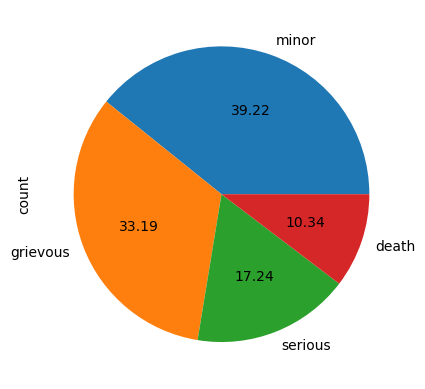

In [104]:
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')

to balance the dataset out and to improve predictions, the following assumptions are made:
1. Grievous and serious injuries are merged into one class
2. 20% of grievous injuries are reclassified as death. According to the WHO, the accident is considered fatal, if death occured 
within a month since the accident (https://cdn.who.int/media/docs/default-source/documents/health-topics/road-traffic-injuries/definition-of-a-road-traffic-death-by-who-and-the-health-sector.pdf?sfvrsn=24c83ea3_3)
According to this study (in the US) (https://pmc.ncbi.nlm.nih.gov/articles/PMC3603725/), 20% of grievously injured people die within a month from the accident.
random reclassification of 20% grievous injuries to death is done only once, for reproducibility.
The reclassed dataset is written into a new file "combined_accidents_balanced.csv" and then loaded for processing.

<Axes: ylabel='count'>

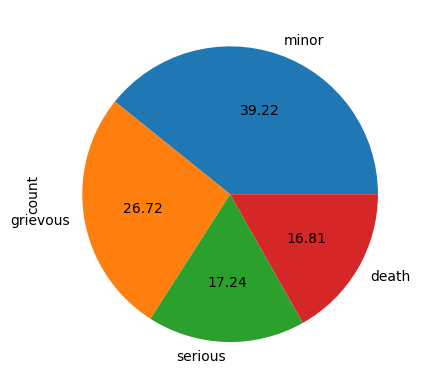

In [105]:
# to balance the dataset out and to improve predictions, the following assumptions are made:
#1. Grievous and serious injuries are merged into one class
#2. 20% of grievous injuries are reclassified as death. According to the WHO, the accident is considered fatal, if death occured 
# within a month since the accident (https://cdn.who.int/media/docs/default-source/documents/health-topics/road-traffic-injuries/definition-of-a-road-traffic-death-by-who-and-the-health-sector.pdf?sfvrsn=24c83ea3_3)
# According to this study (in the US) (https://pmc.ncbi.nlm.nih.gov/articles/PMC3603725/), 20% of grievously injured people die within a month from the accident.
# random reclassification of 20% grievous injuries to death is done only once, for reproducibility.
# The reclassed dataset is written into a new file "combined_accidents_balanced.csv" and then loaded for processing.

#idx_grievous = df.loc[(df['injury_severity']  == 'grievous')].index
#num_idx = round(len(idx_grievous)*0.2)
#index_replace = np.random.choice(idx_grievous, num_idx, replace=False)  
#df.loc[index_replace, 'injury_severity'] = 'death'
#df_balanced = df

#saving the new classes into a new file
#output_file = "combined_accidents_balanced.csv"
#df_balanced.to_csv(output_file, index=False)

df = pd.read_csv('combined_accidents_balanced.csv')
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')

Part 3. Feature Encoding 
--------------------------------------------------------------------------

Random Forests do not require one-hot encoding. The model might perform worse because one-hot encoding adds more columns, meaning a tree would need to split into more leaves, making classification more difficult. For this model, ordinal encoding was chosen. Categorical values need not be scaled, so no scaling was done either. Grievous and serious injuries were merged into one class.

injury_severity
1    102
0     91
2     39
Name: count, dtype: int64


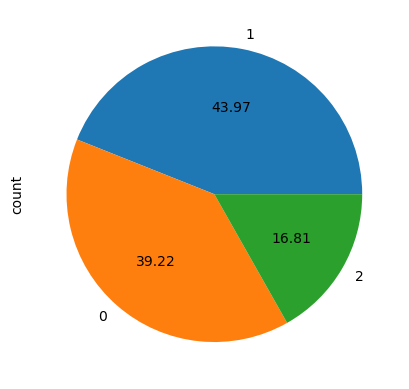

In [106]:
#encoding the injury severity column

#below are the parameters originally chosen for modelling. Rush hour and time period were later dropped since they did not improve predictions

df_sel = df[['injury_severity','affected_party','primary_accident_type_code','day_of_week_num','rain_today','vehicle_type_score','age_min_encoded','rush_hour','time_period']]
#ordinal_mapping_injury = {'minor':0,'serious':1,'grievous':2, 'death':3}
ordinal_mapping_injury = {'minor':0,'serious':1,'grievous':1, 'death':2}
df_sel['injury_severity'] = df_sel['injury_severity'].map(ordinal_mapping_injury)

df_sel['injury_severity'].value_counts().plot.pie(autopct='%.2f')
print(df_sel['injury_severity'].value_counts())

In [107]:
#encoding the affected party column 
ordinal_mapping_ap = {'pedestrian':0,'cyclist':1,'motorcyclist':2, 'driver':3}
df_sel['affected_party'] = df_sel['affected_party'].map(ordinal_mapping_ap)
df_sel['affected_party']

0      0
1      2
2      0
3      3
4      3
      ..
227    0
228    2
229    3
230    2
231    3
Name: affected_party, Length: 232, dtype: int64

In [108]:
#encoding the accident type code column 
ordinal_mapping_at = {'FXOBJ':0,'PED':1,'COLL':2, 'OTH':3}
df_sel['primary_accident_type_code'] = df_sel['primary_accident_type_code'].map(ordinal_mapping_at)
df_sel['primary_accident_type_code']

0      1
1      0
2      1
3      2
4      2
      ..
227    1
228    2
229    2
230    2
231    2
Name: primary_accident_type_code, Length: 232, dtype: int64

In [ ]:
#encoding the rain column 
df_sel['rain_today'] = df_sel['rain_today'].astype(int)
df_sel['rain_today']

0      0
1      0
2      0
3      0
4      0
      ..
227    1
228    0
229    0
230    0
231    0
Name: rain_today, Length: 232, dtype: int32

In [110]:
#encoding time period
ordinal_mapping_tp = {'Night':0,'Morning':1,'Afternoon':2, 'Evening':3}
df_sel['time_period'] = df_sel['time_period'].map(ordinal_mapping_tp)
df_sel['time_period']

0      1
1      3
2      3
3      3
4      3
      ..
227    1
228    1
229    1
230    1
231    1
Name: time_period, Length: 232, dtype: int64

In [111]:
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   injury_severity             232 non-null    int64
 1   affected_party              232 non-null    int64
 2   primary_accident_type_code  232 non-null    int64
 3   day_of_week_num             232 non-null    int64
 4   rain_today                  232 non-null    int32
 5   vehicle_type_score          232 non-null    int64
 6   age_min_encoded             232 non-null    int64
 7   rush_hour                   232 non-null    int64
 8   time_period                 232 non-null    int64
dtypes: int32(1), int64(8)
memory usage: 15.5 KB


Part 4. Data splitting into train, validation and test
-----------------------------------------------------------------


The train (60%) set is for model training, the validation set (20%) is for hyperparameter tuning and the test set (20%) is for the final evaluation of the model performance.
Given that the dataset is small, splitting it into three parts negatively adffects the modelling process. There is not enough data to train, validate and test.

In [112]:
x_params = ['primary_accident_type_code','affected_party','rain_today','vehicle_type_score','age_min_encoded']
X = df_sel[x_params]

y = df_sel['injury_severity']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Show the number of observations for the train, validate and test dataframes
print('Number of observations in the training set:', len(X_train))
print('Number of observations in the validate set:',len(X_val))
print('Number of observations in the test set:',len(X_test))

Number of observations in the training set: 139
Number of observations in the validate set: 46
Number of observations in the test set: 47


In [113]:
y_test.value_counts()

injury_severity
1    21
0    18
2     8
Name: count, dtype: int64

In [114]:
y_val.value_counts()

injury_severity
1    20
0    18
2     8
Name: count, dtype: int64

In [115]:
y_train.value_counts()

injury_severity
1    61
0    55
2    23
Name: count, dtype: int64

Part 5a. Baseline Random Forest Model & Cross-validation, without class balancing
-----------------------------------------------------------------------------------

1. f1 score was selected as the main metric to evaluate the model since the target classes are imbalanced (three times fewer fatalities, than other classes, even with reclassifying 20% of grievous injuries to fatalities). It combines Precision and Recall, the latter is defined below. 
Precision = True Positives / (True Positives + False Positives). F1 score = 2*(Precision * Recall)/Precision + Recall. F1 weighted calculates metrics for each label, and finds their average weighted by support (the number of true instances for each label). It accounts for class imbalance and can result in an F-score that is not between precision and recall.

2. Balanced accuracy was chosen as another metric since it's suitable for multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class (Recall = True Positives / (True Positives + False Negatives))

3. Accuracy was also used as an additional metric: Accuracy score = Number of Correct Predictions / Number of Total Predictions. 


In [116]:
#Initialising the model with default parameters
RFmodel = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42)

# Cross-validation model

f1_scores = cross_val_score(RFmodel, X_train, y_train, cv=5, scoring='f1_weighted') #cross-validation over 5 K-fold splits in training data
mean_f1_scores = np.mean(f1_scores)

bal_accuracy_scores = cross_val_score(RFmodel, X_train, y_train, cv=5, scoring='balanced_accuracy') #cross-validation over 5 K-fold splits in training data
mean_bal_accuracy = np.mean(bal_accuracy_scores)

accuracy_scores = cross_val_score(RFmodel, X_train, y_train, cv=5, scoring='accuracy') #cross-validation over 5 K-fold splits in training data
mean_accuracy = np.mean(accuracy_scores)

# Train the model on the full training data
RFmodel.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_default = RFmodel.predict(X_val)
y_default_score= RFmodel.predict_proba(X_val)#prediction probabilities for each data point

# Calculate f1_weighted and accuracy on the validation set
f1_scores_val = f1_score(y_val, y_pred_default, average='weighted')
bal_accuracy_val = balanced_accuracy_score(y_val, y_pred_default)
accuracy_val = accuracy_score(y_val, y_pred_default)

# Display results
df_labels = pd.Series(['Imbalanced Train Set CV Mean_f1_scores','Imbalanced Train Set CV Mean Balanced Accuracy', 
                       'Imbalanced Train Set CV Mean Accuracy','Imbalanced Train Set / F1 weighted score Val Set',
                       'Imbalanced Train Set/ Balanced Accuracy Val Set','Imbalanced Tain Set/ Accuracy Val Set'], name='Performance_Metrics:')
df_values = pd.Series([mean_f1_scores, mean_bal_accuracy,mean_accuracy,f1_scores_val,bal_accuracy_val,accuracy_val],name = 'Performance_Metrics_Values')
df1 = pd.concat([df_labels, df_values], axis =1)
df1

#the CV metrics show that the model safficiently generalises over the training set. 


,Performance_Metrics:,Performance_Metrics_Values
0,Imbalanced Train Set CV Mean_f1_scores,0.677127
1,Imbalanced Train Set CV Mean Balanced Accuracy,0.589565
2,Imbalanced Train Set CV Mean Accuracy,0.691270
3,Imbalanced Train Set / F1 weighted score Val Set,0.710115
4,Imbalanced Train Set/ Balanced Accuracy Val Set,0.681481
5,Imbalanced Tain Set/ Accuracy Val Set,0.717391


Part 5b. Baseline Random Forest Model and Cross-validation, with Random Oversampling
---------------------------------------------------------------------------------------------------

In [117]:
#the dataset is imbalanced, so let us oversample minority classes to balance the data out

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42, sampling_strategy='not majority')

X_res_ros, y_res_ros = ros.fit_resample(X_train,y_train)
y_res_ros.value_counts()

injury_severity
1    61
2    61
0    61
Name: count, dtype: int64

In [118]:
#Initialising the model with default parameters
RFmodel = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42)

# Cross-validation model with oversampled minority class in the training data
f1_scores_res_ros = cross_val_score(RFmodel, X_res_ros, y_res_ros, cv=5, scoring='f1_weighted') #cross-validation over 5 K-fold splits in training data
mean_f1_scores_res_ros = np.mean(f1_scores_res_ros)

bal_accuracy_scores_res_ros = cross_val_score(RFmodel, X_res_ros, y_res_ros, cv=5, scoring='balanced_accuracy') #cross-validation over 5 stratified K-fold train-test splits
mean_bal_accuracy_res_ros = np.mean(bal_accuracy_scores_res_ros)

accuracy_scores_res_ros = cross_val_score(RFmodel, X_res_ros, y_res_ros, cv=5, scoring='accuracy') #cross-validation over 5 stratified K-fold train-test splits
mean_accuracy_res_ros = np.mean(accuracy_scores_res_ros)

# Train the model on the full training data
RFmodel.fit( X_res_ros, y_res_ros)

# Make predictions on the validation set
y_pred_res_ros = RFmodel.predict(X_val)

# Calculate f1_weighted, balanced accuracy and accuracy on the validation set
f1_scores_val_res_ros = f1_score(y_val, y_pred_res_ros, average='weighted')
bal_accuracy_val_res_ros = balanced_accuracy_score(y_val, y_pred_res_ros)
accuracy_val_res_ros = accuracy_score(y_val, y_pred_res_ros)

# Display results

df_labels = pd.Series(['Oversampled Train Set CV Mean_f1_scores','OversampledTrain Set CV Mean Balanced Accuracy', 
                       'Oversampled Train Set CV Mean Accuracy','Oversampled Train Set / F1 weighted score Val Set',
                       'Oversampled Tain Set/ Balanced Accuracy Val Set','Oversampled Tain Set/ Accuracy Val Set'], name='Performance_Metrics:')
df2_values = pd.Series([mean_f1_scores_res_ros, mean_bal_accuracy_res_ros,mean_accuracy_res_ros,f1_scores_val_res_ros,bal_accuracy_val_res_ros,accuracy_val_res_ros],name = 'Performance_Metrics_Values')
df2 = pd.concat([df_labels, df2_values], axis =1)
df2

,Performance_Metrics:,Performance_Metrics_Values
0,Oversampled Train Set CV Mean_f1_scores,0.696312
1,OversampledTrain Set CV Mean Balanced Accuracy,0.699573
2,Oversampled Train Set CV Mean Accuracy,0.700150
3,Oversampled Train Set / F1 weighted score Val Set,0.732525
4,Oversampled Tain Set/ Balanced Accuracy Val Set,0.773148
5,Oversampled Tain Set/ Accuracy Val Set,0.739130


4d. Baseline Crossvalidation (Imbalanced and Oversampled), comparison

In [119]:
df3 = pd.concat([df1.Performance_Metrics_Values, 
                df2.Performance_Metrics_Values,
                            ], axis =1)

df3.columns = ['No class balancing', 'Random Oversampling']
df3 = df3.T
df3.columns = ['CV Mean_f1_scores', 'CV Mean_Balanced_Accuracy','CV Mean Accuracy', 'f1_score Val Set', 'Balanced Accuracy Val Set','Accuracy Val Set']
df3

,CV Mean_f1_scores,CV Mean_Balanced_Accuracy,CV Mean Accuracy,f1_score Val Set,Balanced Accuracy Val Set,Accuracy Val Set
No class balancing,0.677127,0.589565,0.69127,0.710115,0.681481,0.717391
Random Oversampling,0.696312,0.699573,0.70015,0.732525,0.773148,0.739130


The metrics show that the training set with random oversampling is better at classifying target classes, so I will use it for hyperparameter tuning.

6a. Model training and hyperparameter tuning using the validation set
--------------------------------------------------------------------------------

In [120]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 30, 50, 70],  
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10, 12],  
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2', None],
   }

score = ["accuracy", "balanced_accuracy", "f1_weighted"]

# Initialize the Random Forest model
RFmodel = RandomForestClassifier(random_state=42)
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=RFmodel, 
                           param_grid=param_grid,
                           n_jobs=-1,
                           cv = 5, scoring=score,  refit="f1_weighted")

# Fit GridSearchCV to the oversampled training data
grid_search.fit(X_res_ros, y_res_ros)
#grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV and make predictions using the validation set
best_rf_model = grid_search.best_estimator_
y_pred_gs = best_rf_model.predict(X_val)

# Calculate f1 score and accuracy for the best model
f1_scores = f1_score(y_val, y_pred_gs,average='weighted')
bal_accuracy = balanced_accuracy_score(y_val, y_pred_gs)
accuracy = accuracy_score(y_val, y_pred_gs)

#CV mean weighted F1 score
f1_scores_all = grid_search.cv_results_['mean_test_f1_weighted']
mean_f1_scores_all = np.mean(f1_scores_all)
std_f1_scores_all = np.std(f1_scores_all)

#CV mean balanced accuracy score
bal_acc_scores_all = grid_search.cv_results_['mean_test_balanced_accuracy']
mean_bal_acc_scores_all = np.mean(bal_acc_scores_all)
std_bal_acc_scores_all = np.std(bal_acc_scores_all)

#CV mean accuracy score
acc_scores_all = grid_search.cv_results_['mean_test_accuracy']
mean_acc_scores_all = np.mean(acc_scores_all)
std_acc_scores_all = np.std(acc_scores_all)

#Mean fit time
fit_time_all = grid_search.cv_results_['mean_fit_time']
mean__fittime_all = np.mean(fit_time_all)
std_fittime_all = np.std(fit_time_all)

# Display results
print(f"Best Hyperparameters from Grid Search: {grid_search.best_params_}")
print(f"Grid Search Mean F1 Weighted Score: {mean_f1_scores_all:.2f} ± {std_f1_scores_all:.2f}")
print(f"Grid Search Mean Balanced Accuracy Score: {mean_bal_acc_scores_all:.2f} ± {std_bal_acc_scores_all:.2f}")
print(f"Grid Search Mean Accuracy Score: {mean_acc_scores_all:.2f} ± {std_acc_scores_all:.2f}")
print(f"Best Model F1 Weighted Score: {f1_scores:.2f}")
print(f"Best Model Balanced Accuracy: {bal_accuracy:.2f}")
print(f"Best Model Accuracy: {accuracy:.2f}")
print(f"Grid Search Mean Fit Time, s: {mean__fittime_all:.2f} ± {std_fittime_all:.2f}")


Best Hyperparameters from Grid Search: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 30}
Grid Search Mean F1 Weighted Score: 0.70 ± 0.02
Grid Search Mean Balanced Accuracy Score: 0.71 ± 0.02
Grid Search Mean Accuracy Score: 0.71 ± 0.02
Best Model F1 Weighted Score: 0.73
Best Model Balanced Accuracy: 0.77
Best Model Accuracy: 0.74
Grid Search Mean Fit Time, s: 0.14 ± 0.08


The metrics are very close to those obtained by the model with default parameters.

6b. Hyperparameter visualisation
-------------------------------------------------------------------------------------

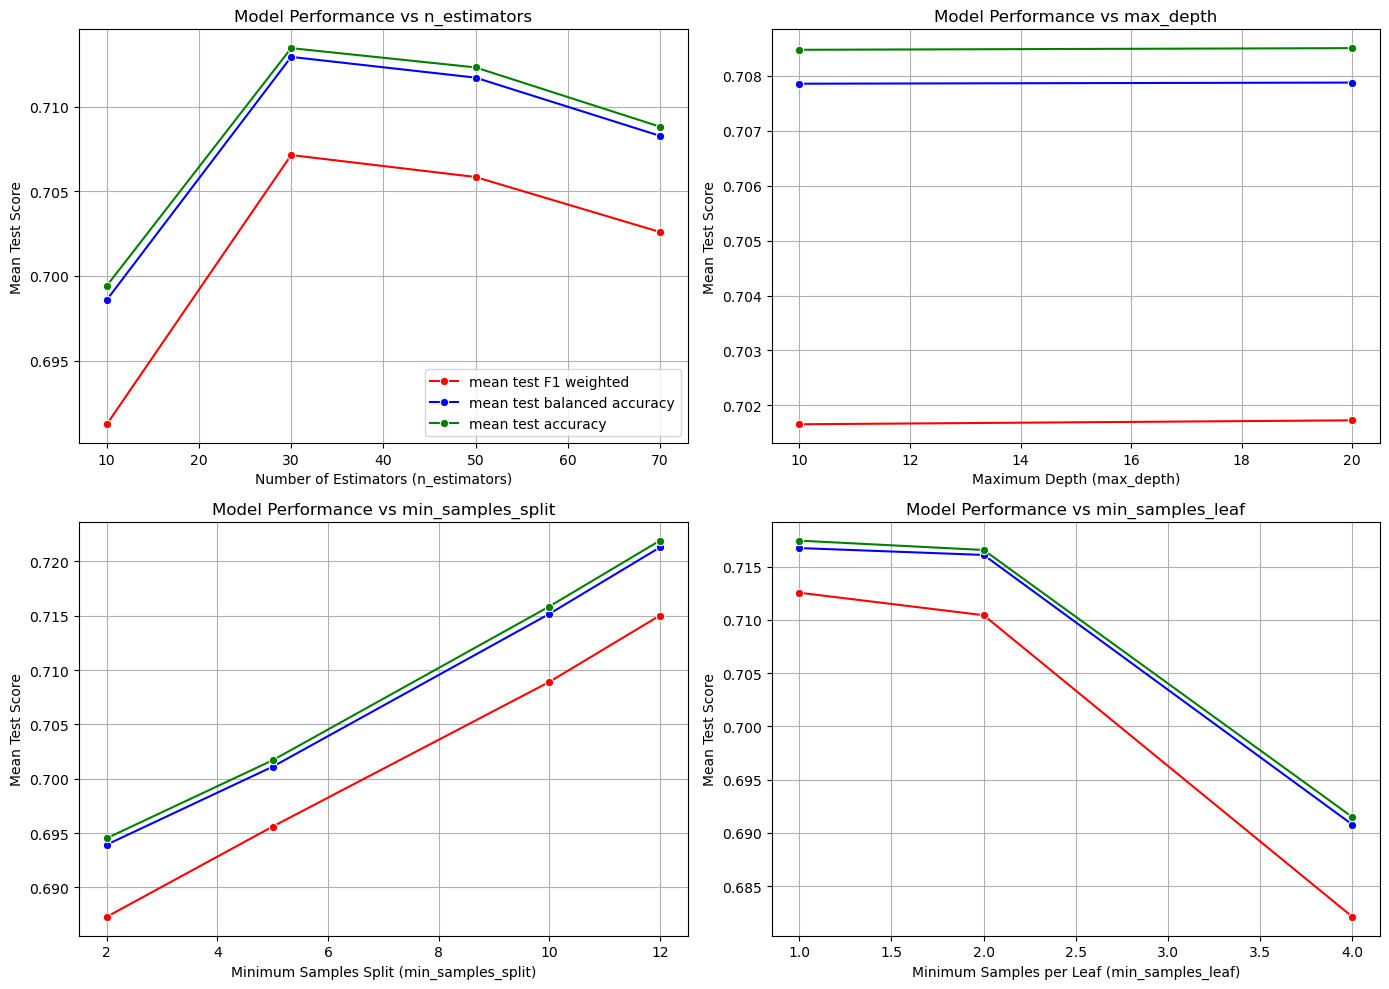

In [121]:
#visualising the Grid Search results

# Assuming grid_search.cv_results_ contains the results of GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)
# Set up the figure with 2 rows and 2 columns
plt.figure(figsize=(14, 10))
# Plot 1: Performance vs n_estimators
plt.subplot(2, 2, 1)
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_f1_weighted', marker='o', color='red', ci=None)
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_balanced_accuracy', marker='o', color='blue', ci=None)
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_accuracy', marker='o', color='green', ci=None)
plt.title('Model Performance vs n_estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score')
plt.legend(labels = ['mean test F1 weighted', 'mean test balanced accuracy','mean test accuracy'], loc='best')
plt.grid(True)
# Plot 2: Performance vs max_depth
plt.subplot(2, 2, 2)
sns.lineplot(data=results, x='param_max_depth', y='mean_test_f1_weighted', marker='o', color='red', ci=None)
sns.lineplot(data=results, x='param_max_depth', y='mean_test_balanced_accuracy', marker='o', color='blue', ci=None)
sns.lineplot(data=results, x='param_max_depth', y='mean_test_accuracy', marker='o', color='green', ci=None)
plt.title('Model Performance vs max_depth')
plt.xlabel('Maximum Depth (max_depth)')
plt.ylabel('Mean Test Score')
plt.grid(True)
# Plot 3: Performance vs min_samples_split
plt.subplot(2, 2, 3)
sns.lineplot(data=results, x='param_min_samples_split', y='mean_test_f1_weighted', marker='o', color='red', ci=None)
sns.lineplot(data=results, x='param_min_samples_split', y='mean_test_balanced_accuracy', marker='o', color='blue', ci=None)
sns.lineplot(data=results, x='param_min_samples_split', y='mean_test_accuracy', marker='o', color='green', ci=None)
plt.title('Model Performance vs min_samples_split')
plt.xlabel('Minimum Samples Split (min_samples_split)')
plt.ylabel('Mean Test Score')
plt.grid(True)
# Plot 4: Performance vs min_samples_leaf
plt.subplot(2, 2, 4)
sns.lineplot(data=results, x='param_min_samples_leaf', y='mean_test_f1_weighted', marker='o', color='red', ci=None)
sns.lineplot(data=results, x='param_min_samples_leaf', y='mean_test_balanced_accuracy', marker='o', color='blue', ci=None)
sns.lineplot(data=results, x='param_min_samples_leaf', y='mean_test_accuracy', marker='o', color='green', ci=None)
plt.title('Model Performance vs min_samples_leaf')
plt.xlabel('Minimum Samples per Leaf (min_samples_leaf)')
plt.ylabel('Mean Test Score')
plt.grid(True)
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

6c. Model Tuning: Applying the best hyperparameters to the test data set
----------------------------------------------------------------------------

In addition to the hyperparameters found via GridSearch, I will use class weights to further improve classification of the minority class (death)

In [122]:
dict_weights = {0:1, 1: 1, 2:2} #further improving the metrics by giving more weight to the minority category

#best hyperparameters 
RFmodel_tuned = RandomForestClassifier(
  n_estimators=30,
  max_depth = None,
  min_samples_split=10,
  min_samples_leaf=1,
  max_features= None,
  class_weight=dict_weights,
  random_state=42)

# Train the model on the training data 
RFmodel_tuned.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_tuned = RFmodel_tuned.predict(X_test)
y_tuned_score = RFmodel_tuned.predict_proba(X_test)#prediction probabilities for each data point

# Calculate metrics on the test set
f1_scores_test = f1_score(y_test, y_pred_tuned,average='weighted')
bal_accuracy_test = balanced_accuracy_score(y_test, y_pred_tuned)
accuracy_test = accuracy_score(y_test, y_pred_tuned)

print(f"Tuned Model Test Set F1 score: {f1_scores_test:.2f}")
print(f"Tuned Model Test Set Balanced Accuracy: {bal_accuracy_test:.2f}")
print(f"Tuned Model Test Set Accuracy: {accuracy_test:.2f}")



Tuned Model Test Set F1 score: 0.80
Tuned Model Test Set Balanced Accuracy: 0.76
Tuned Model Test Set Accuracy: 0.79


##7. Assessing the Performance of the Tuned Model
----------------------------------------------------------------------


7a. Classification Report and Confusion Matrix
-----------------------------------------------

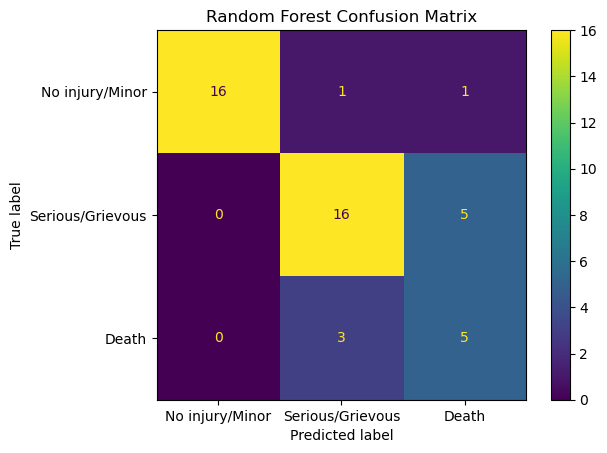

Minor/No Injuiry Cases Correctly Identified: 16/18 (88.9%)
Serious/Grievous Injuiry Cases Correctly Identified: 16/21 (76.2%)
Death Cases Correctly Identified: 5/8 (62.5%)


In [123]:
cm = confusion_matrix(y_test, y_pred_tuned)
cm_labels = pd.DataFrame(data=cm, index =['No injury/Minor','Serious/Grievous','Death'], columns=['No injury/Minor','Serious/Grievous','Death'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cm_labels)
disp.plot()
disp.ax_.set_title("Random Forest Confusion Matrix")
plt.show()

minor_correct = cm[0,0]
minor_total = cm[0].sum()
print(f"Minor/No Injuiry Cases Correctly Identified: {minor_correct}/{minor_total} ({minor_correct/minor_total:.1%})")

grievous_correct = cm[1,1]
grievous_total = cm[1].sum()
print(f"Serious/Grievous Injuiry Cases Correctly Identified: {grievous_correct}/{grievous_total} ({grievous_correct/grievous_total:.1%})")

death_correct = cm[2,2]
death_total = cm[2].sum()
print(f"Death Cases Correctly Identified: {death_correct}/{death_total} ({death_correct/death_total:.1%})")

In [124]:
#printing classification report
print(f"Tuned Model Classification Report:")
print(classification_report(y_test, y_pred_tuned))

Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.80      0.76      0.78        21
           2       0.45      0.62      0.53         8

    accuracy                           0.79        47
   macro avg       0.75      0.76      0.75        47
weighted avg       0.82      0.79      0.80        47



The tuned model (above) classification of class 1 (Serious/Grievous) and class 2 (Death) was more precise compared to the baseline model (below)

In [125]:
print(f"Baseline Model Classification Report:")
print(classification_report(y_val, y_pred_default))

Baseline Model Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        18
           1       0.71      0.60      0.65        20
           2       0.50      0.50      0.50         8

    accuracy                           0.72        46
   macro avg       0.67      0.68      0.67        46
weighted avg       0.71      0.72      0.71        46



7b. Printing the Metrics of the Default Model, the Model with Random Oversampling and the Tuned Model
-------------------------------------------------------------------------------------------------------

In [126]:
dfcomparison_labels = pd.Series(['F1Score','balanced_accuracy','accuracy'], name='Performance_Metrics:')
dfcomparison_values1 = pd.Series([round(f1_scores_val,2),round(bal_accuracy_val,2), round(accuracy_val,2)],name = 'Default_Model')
dfcomparison_values2 = pd.Series([round(f1_scores_val_res_ros,2), round(bal_accuracy_val_res_ros,2), round(accuracy_val_res_ros,2)], name = 'Default_RandomOversampling')
dfcomparison_values3 = pd.Series([round(f1_scores_test,2), round(bal_accuracy_test,2), round(accuracy_test,2)],name = 'Tuned_Model')
df_comparison = pd.concat([dfcomparison_labels, dfcomparison_values1, dfcomparison_values2, dfcomparison_values3], axis =1)
df_comparison

,Performance_Metrics:,Default_Model,Default_RandomOversampling,Tuned_Model
0,F1Score,0.71,0.73,0.80
1,balanced_accuracy,0.68,0.77,0.76
2,accuracy,0.72,0.74,0.79


7c. ROC and Precision-Recall Curves
---------------------------------------------------


The Precision-Recall Curve is better suited to evaluate a model performance of imbalanced datasets

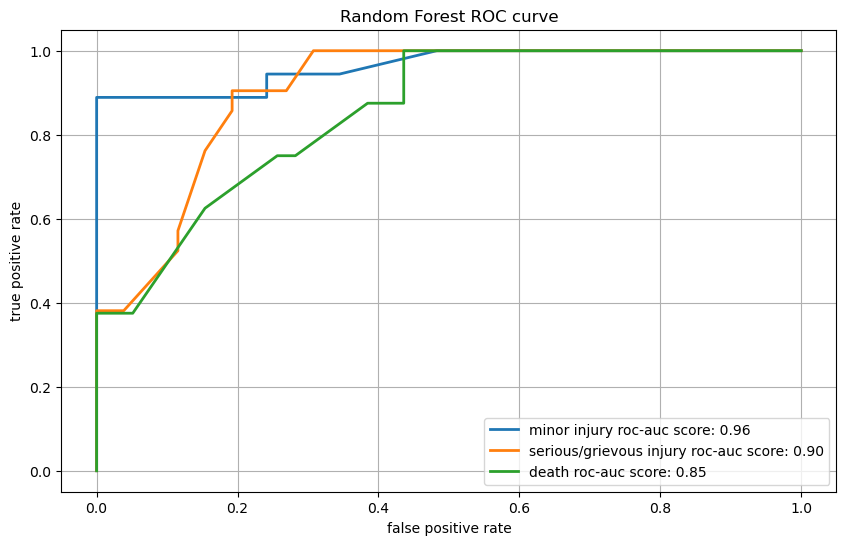

In [127]:
#roc curve

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

# roc curve
fpr = dict() #false positives
tpr = dict() #true positives
RF_roc_auc = dict() #roc_auc_score

n_classes = len(set(y_test))

y_test_bin = label_binarize(y_test, classes=[*range(n_classes)])

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i],
                                  y_tuned_score[:, i])
    RF_roc_auc[i] = roc_auc_score(y_test_bin[:, i],
                                  y_tuned_score[:, i])

    
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

label1 = (f"minor injury roc-auc score: {RF_roc_auc[0]:.2f}")
label2 = (f"serious/grievous injury roc-auc score: {RF_roc_auc[1]:.2f}")
label3 = (f"death roc-auc score: {RF_roc_auc[2]:.2f}")
plt.legend(labels = [label1, label2, label3],loc="best")
plt.title("Random Forest ROC curve")
plt.grid(True)
plt.show()


In the case of a well-performing model, the true positive rates shoots up close to 1 almost immediately and then moves on horizontally.
The model is most confident at classifying minor injuries (which is expected since the dataset includes multiple instances of minor injuries for drivers in collisions).
The model is least confident at predicting fatalities.

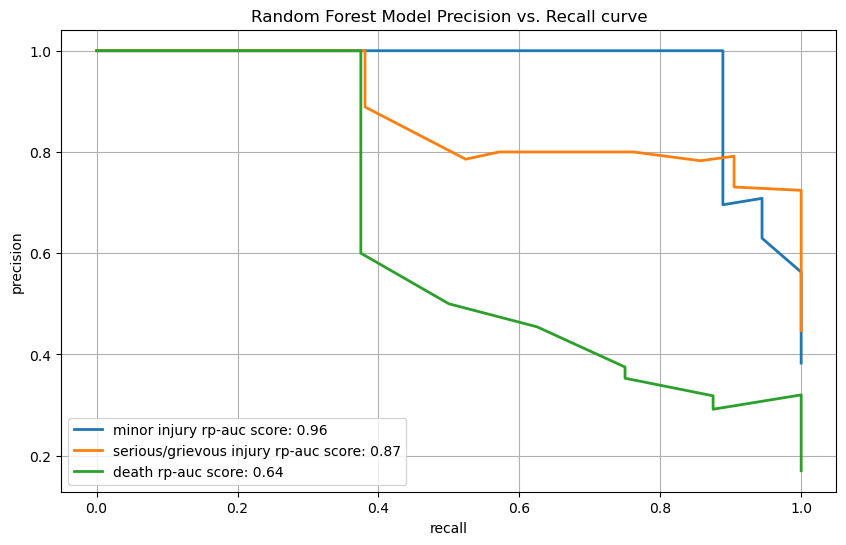

In [128]:
#https://www.blog.trainindata.com/precision-recall-curves/
#https://www.youtube.com/watch?v=rlZVRpMAbTg

precision = dict()
recall = dict()
rp_auc_score = dict() #pr_auc score

# Generate precision-recall curve
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision[i], recall[i],_ = precision_recall_curve(y_test_bin[:, i],
                                                        y_tuned_score[:,i])
    rp_auc_score[i] = auc(recall[i],precision[i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

    
plt.xlabel("recall")
plt.ylabel("precision")

label1 = (f"minor injury rp-auc score: {rp_auc_score[0]:.2f}")
label2 = (f"serious/grievous injury rp-auc score: {rp_auc_score[1]:.2f}")
label3 = (f"death rp-auc score: {rp_auc_score[2]:.2f}")
plt.legend(labels = [label1, label2, label3],loc="best")
plt.title("Random Forest Model Precision vs. Recall curve")
plt.grid(True)
plt.show()

The recall-precision auc for death is lower than the roc_auc for the same category. This means that the model performs worse at finding positive values for this category.
This metric is more appropriate for datasets with significant class imbalance.

##8. Feature Importance Metrics
-----------------------------------------------

Gini Impurity: a measure of how "mixed" the classes are within a given node of a decision tree. 

Higher Gini Importance means the feature was used more often and more effectively to split the data into cleaner, more homogeneous groups.

Lower Gini Importance suggests the feature had less impact on the decision-making process within the model.

In [129]:
# Gini Importance
targets = np.array(['No injury/Minor','Serious/Grievous','Death'])
features = np.array(x_params)

importances = RFmodel_tuned.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': features, 'Gini Importance': importances}).sort_values(
    'Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
1,affected_party,0.389977
0,primary_accident_type_code,0.302324
3,vehicle_type_score,0.164252
4,age_min_encoded,0.091886
2,rain_today,0.051561


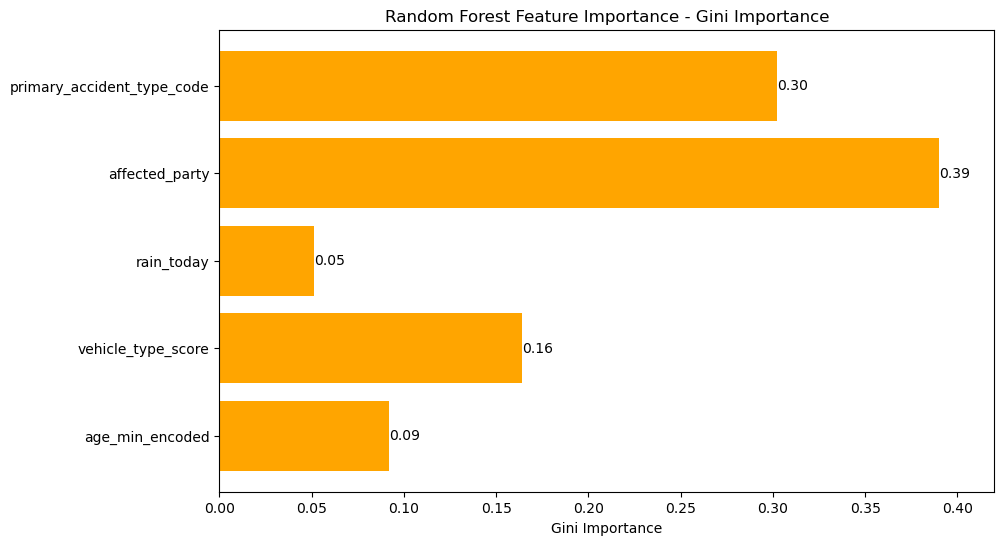

In [169]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,6)

hbars = ax.barh(features, importances, color='orange', align='center')
ax.set_yticks(features, labels=features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Gini Importance')
ax.set_title('Random Forest Feature Importance - Gini Importance')

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%.2f')
ax.set_xlim(right=0.42)  # adjust xlim to fit labels

plt.show()

Permutation importance: computed once a model has been trained on the training set. It inquires: If the data points of a single attribute are randomly shuffled (in the test set), leaving all remaining data as is, what would be the ramifications on accuracy, using this new data?
Ideally, random reordering of a column ought to result in reduced accuracy, since the new data has little or no correlation with real-world statistics.
Model accuracy suffers most when an important feature, that the model was quite dependent on, is shuffled. 

This parameter provides an insight into what features matter the most at the classification task.

https://www.geeksforgeeks.org/machine-learning/machine-learning-explainability-using-permutation-importance/

In [131]:
#permutation importance

from sklearn.inspection import permutation_importance
result = permutation_importance(
    RFmodel_tuned, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': features, 'Permutation Importance': result.importances_mean}).sort_values(
    'Permutation Importance', ascending=False)
perm_imp_df

,Feature,Permutation Importance
1,affected_party,0.282979
0,primary_accident_type_code,0.105674
4,age_min_encoded,0.050355
3,vehicle_type_score,0.043262
2,rain_today,0.029078


[Text(0, 0, '0.28'),
 Text(0, 0, '0.11'),
 Text(0, 0, '0.05'),
 Text(0, 0, '0.04'),
 Text(0, 0, '0.03')]

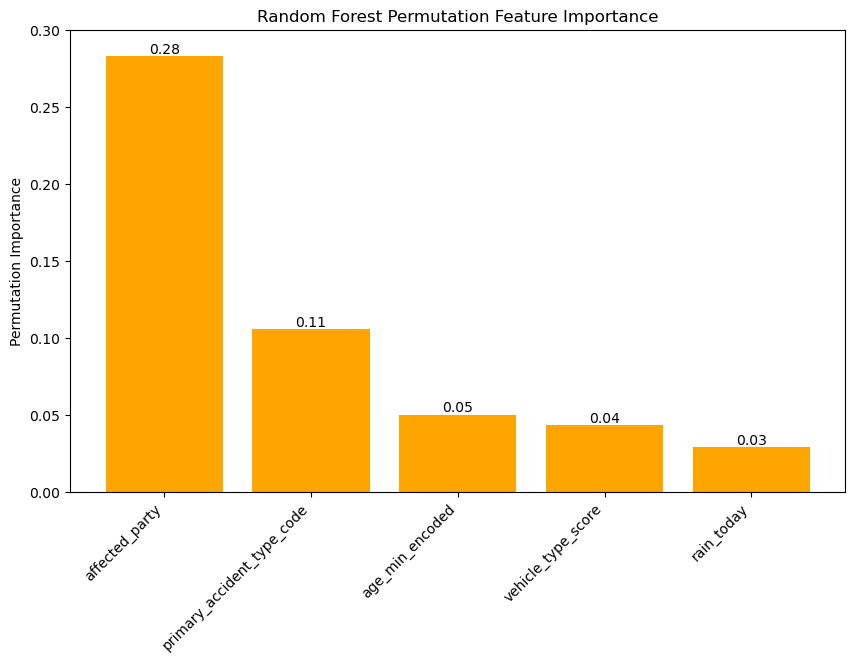

In [176]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,6)
bar_container = ax.bar(perm_imp_df['Feature'], perm_imp_df['Permutation Importance'],color='orange')
ax.set(ylabel='Permutation Importance', title='Random Forest Permutation Feature Importance', ylim=(0, 0.3))
ax.set_xticklabels(perm_imp_df['Feature'],rotation=45, ha='right')
ax.bar_label(bar_container, fmt='{:,.2f}')

The permutation importance of the 'affected party' feature is significantly greater than that of the rest. This means it's the most important parameter for classification.
Primary accident type code is the 2nd most significant feature, followed by age_min_encoded (representing the age of (youngest, for collisons) driver involved in the accident).
The significance of rain for predictions is the lowest (both Gini and permutation importance)

In [182]:
#saving results into a separate df for comparisons

dfresults_labels = pd.Series(['F1Score','balanced_accuracy','accuracy','mean fit time'], name='Performance_Metrics:')
dfresults_values = pd.Series([f1_scores_test, bal_accuracy_test, accuracy_test, mean__fittime_all],name = 'Random_Forest_Metrics_Values')
df_results = pd.concat([dfresults_labels, dfresults_values], axis =1)
df_results

metrics_file = "results/RF_performance_metrics.csv"
df_results.to_csv(metrics_file, index=False)

#X test values 
RF_Xtest_file = "results/Xtest.csv"
X_test.to_csv(RF_Xtest_file, index=False)

#RF Y test values
RF_Ytest_file = "results/RF_Ytest.csv"
y_test.to_csv(RF_Ytest_file, index=False)

#RF Y predicted values
RF_Ypred_file = "results/RF_Ypred.csv"
df_y_pred = pd.DataFrame(y_pred_tuned)
df_y_pred.to_csv(RF_Ypred_file, index=False)

#Y prediction probabilities for the curve analysis
RF_Yscore_file = "results/RF_Y_pred_score.csv"
df_y_pred_score = pd.DataFrame(y_tuned_score)
df_y_pred_score.to_csv(RF_Yscore_file, index=False)

#gini importance
RF_gini_file = "results/RF_Gini_Importance.csv"
feature_imp_df.to_csv(RF_gini_file, index=False)

#permutation importance
RF_perm_file = "results/RF_Perm_Importance.csv"
perm_imp_df.to_csv(RF_perm_file, index=False)

8. Tree Visualisation

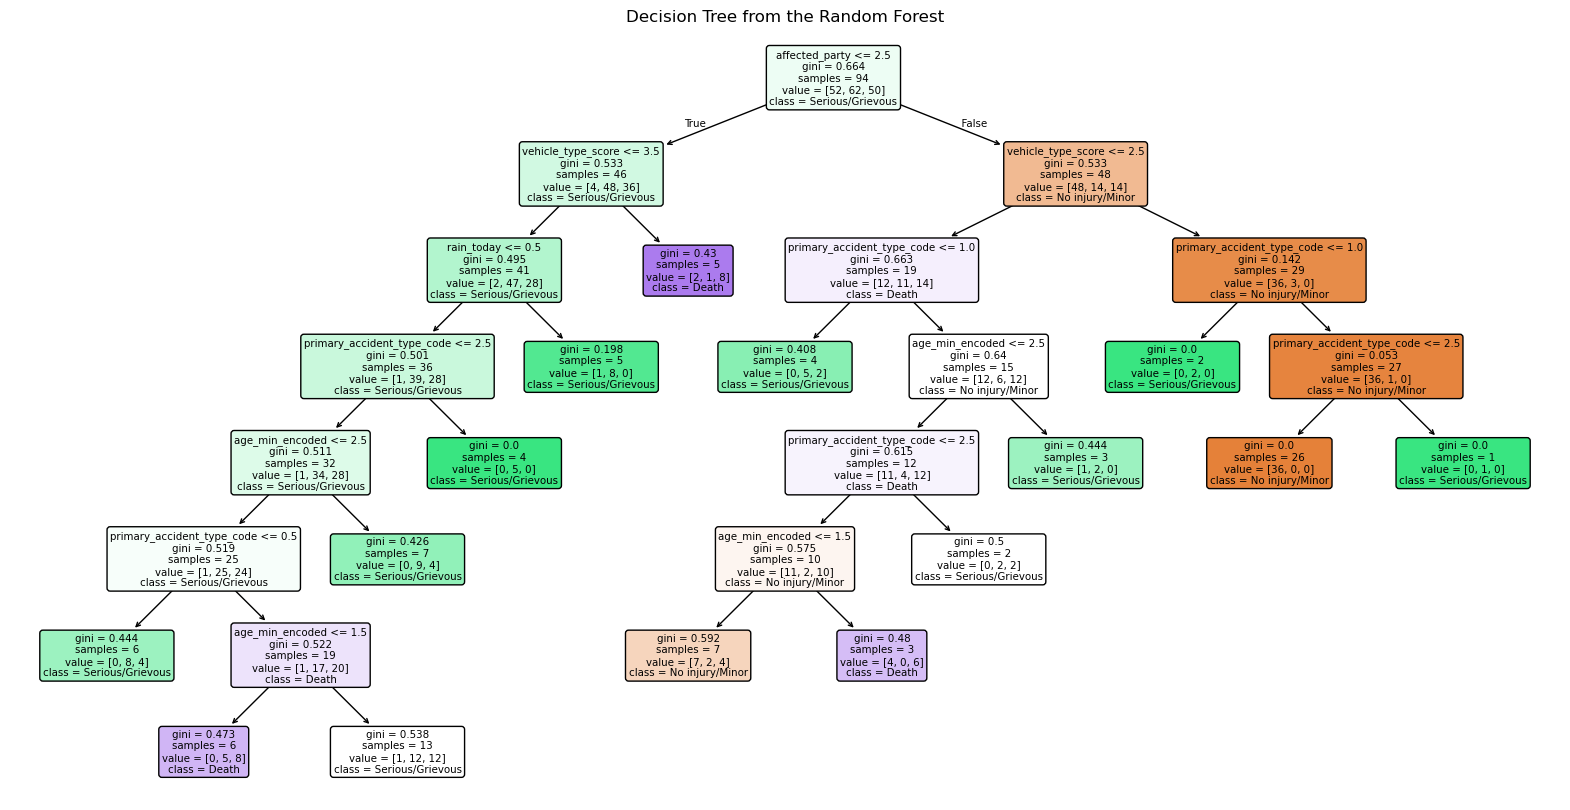

In [134]:
# Extract an individual decision tree from the Random Forest
from sklearn import tree
from sklearn.tree import plot_tree

targets = np.array(['No injury/Minor','Serious/Grievous','Death'])
features = np.array(x_params)

tree = RFmodel_tuned.estimators_[0]  # Get the first tree 

# Plot the tree using the plot_tree function from sklearn
plt.figure(figsize=(20,10))  # Set figure size 
plot_tree(tree, 
          feature_names=features,  # Use the feature names from the dataset
          class_names=targets,  # Use class names (species names)
          filled=True,              # Fill nodes with colors for better visualization
          rounded=True)             # Rounded edges for nodes
plt.title("Decision Tree from the Random Forest")
plt.show()


Insights about the accidents:
-------------------------------

Random Forest technique is a black box, although the feature importance metrics offer insight into the model classification process. Visualising a single tree helps to better interpret the classification process, however this is not enough to get the full picture of the model. The features that have the greatest impact on the classification outcome are the affected party (pedestrian, cyclist, motorcyclist and driver/passenger), the accident type (run-overs, collisions with fixed objects, collisions between vehicles and other (overturning, losing control of the vehicle)). The affected party is main node of the model. 

Following the decision process of the single tree above, we understand that a car driver (affected party <=2.5) involved into an accident between two cars (vehicle type score <= 2.5) is likely to have a minor injury. 

A non-car driver (pedestrian, cyclist, motorcyclist) injuired in an accident that involves large vehicles (vehicle type score > 3.5) might die.

A non-car driver injuired in an accident that does not involves large vehicles (vehicle type score <= 3.5) might be seriously/grievously injuired. This applies to pedestrians being run over by cars, motorcyclists colliding with fixed objects and motorcyclists colliding with cars.

The classification process of this single tree appears logical and corresponds to the real-life cases.

Limitations, Suggested Improvements and Ethical Considerations
-------------------------------------------------------------

Limitations: 
------------------------------------------------

1. The bias in the source data as well as the small size of the dataset are the major limitations of this project. The bias in the source data is due to the nature of the source: the media and the police report on grievous injuries and fatalities. The minor accidents do not make it to the news articles and police reports. Thus, the extracted data primarily features serious and grievous injuries, and some fatalities. 

2. According to the NSO, minor injuries are the most common injury category. Our dataset, however, contained only a few of such instances. From studying the data, it was observed that collisions often report the injury of only one party involved (case in point, in collisions between a car and a motorcycle, the affected party was always the motorcyclist, whereas the driver's injury was not mentioned). Thus, for every collision, another affected party was added - a driver, with minor injuries. This added a significant bias to the dataset, since the majority of minor injuries included drivers involved in collisions. The model lacked training examples for other types of minor injuries.

3. The injury severity target classes would always be imbalanced since there are (thankfully) many fewer fatalities than injuries. This means that the training data on fatalities are not easily obtained, and even larger datasets would still be affected by class imbalance.

4. The model did not take road type into account. Since the majority of accidents mentioned in the source had seriously and grievously injured people, the location would not make a difference in our case. However, road type could be a decisive feature to predict injury severity since the collisions on regional roads have a far more devastating impact than those on country roads or local roads. Also, road type and locality can benefit from historic data on the outcome of various types of accidents in this specific spot.

5. The model did not take driver sex into account for ethical reasons. Although the significance of driver sex on the accident outcome has been statistically proven, we did not extract this information for ethical reasons.


Suggested Improvements:
----------------------------------------------------

1. Collect more data on accidents that result in minor injuries to avoid the bias.
2. Take road type into account since the road type and speed limits have an impact on the accident severity.
3. For collisions, the safety features of the vehicle could determine which driver gets a more severe injury in collisions between vehicles.

Ethical Considerations:
----------------------------------------------------
The results of this projects should be taken into consideration to the safety of commute for everyone, especially the most vulnerable groups such as pedestrians and cyclists

